<a href="https://colab.research.google.com/github/YuriGribauskasDenis/SmallNetworkPlusPlus/blob/main/small_mobile_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import keras.backend as BCKN
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate
from keras.layers import Dense, Conv2D, DepthwiseConv2D, Dropout, Flatten
from keras.layers import GlobalAveragePooling2D, Reshape
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import ReLU, Softmax, LeakyReLU
from keras.layers import BatchNormalization as BN
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import regularizers

In [2]:
def preprocess_image(image, size):
  image = keras.preprocessing.image.smart_resize(
      image, size, interpolation='bilinear'
    )
  return image

In [3]:
def small_network():

  first = Input((100,100,1))
  model = MaxPooling2D(pool_size=2) (first)
  
  lambd = 0.1
  reglar = regularizers.L1L2(l1=1e-5, l2=1e-4)

  model = Conv2D (16, kernel_size=3, strides=1, padding='same', kernel_regularizer=reglar) (model)
  model = ReLU() (model)
  model = Conv2D (16, kernel_size=3, strides=1, padding='same', kernel_regularizer=reglar) (model)
  model = ReLU() (model)
  model = AveragePooling2D(pool_size=2) (model)

  model = Conv2D (24, kernel_size=3, strides=1, padding='same', kernel_regularizer=reglar) (model)
  model = ReLU() (model)
  model = Conv2D (24, kernel_size=3, strides=1, padding='same', kernel_regularizer=reglar) (model)
  model = ReLU() (model)
  model = AveragePooling2D(pool_size=(2, 2)) (model)

  model = Conv2D (32, kernel_size=3, strides=1, padding='same', kernel_regularizer=reglar) (model)
  model = GlobalAveragePooling2D() (model)
  model = Flatten() (model)
  model = Dense(3) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

In [4]:
BCKN.clear_session()
model = small_network()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 1)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        160       
                                                                 
 re_lu (ReLU)                (None, 50, 50, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 re_lu_1 (ReLU)              (None, 50, 50, 16)        0         
                                                             

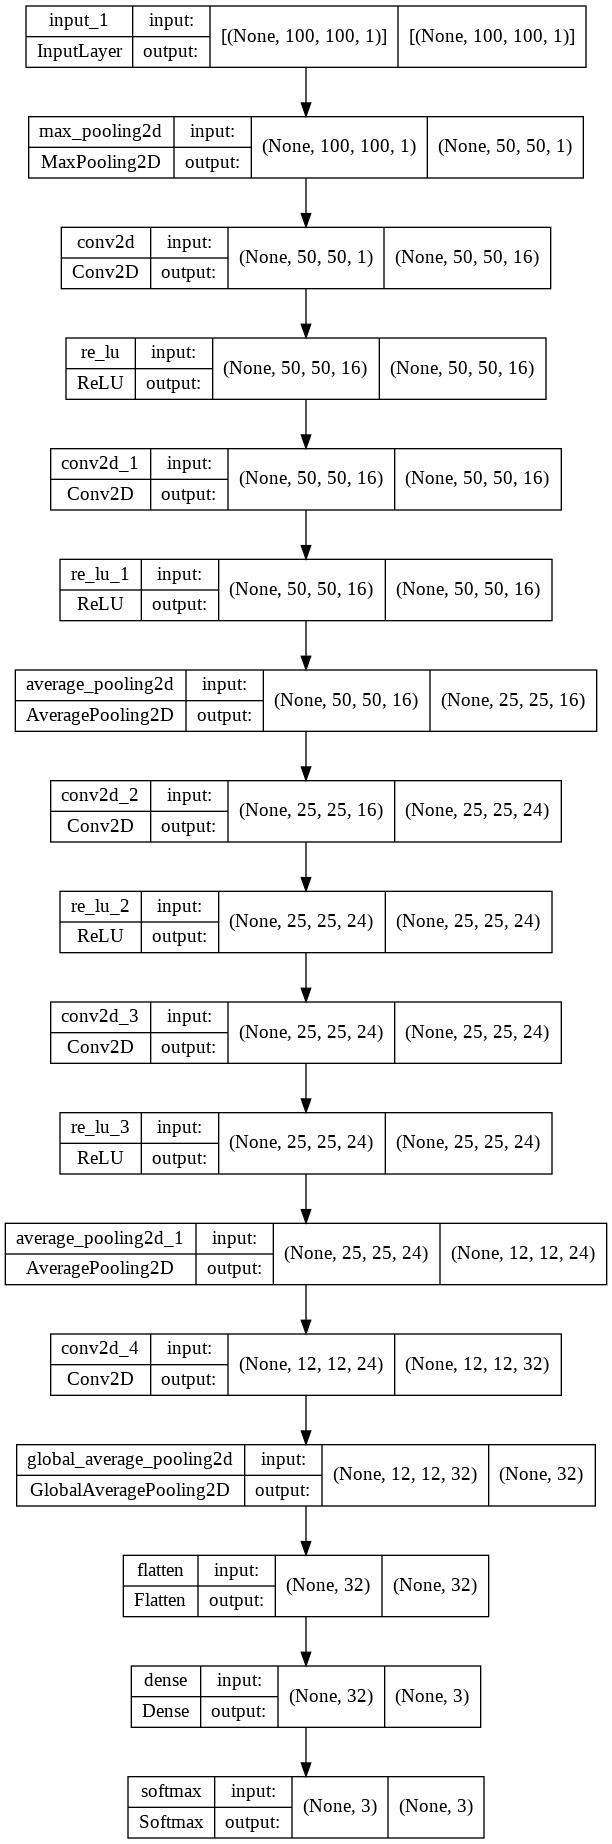

In [5]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.0)
optimizer = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True, clipnorm=1.0)
# loss_fn = 'categorical_crossentropy'
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

In [13]:
import numpy as np
Z = np.array([np.random.random((100,100,1)) for _ in range(160)])
print(Z.shape)
X  = np.random.rand(160, 100, 100, 1)
print(X.shape)
print(X[2].shape)
y = np.random.randint(2, size=160)
print(y.shape)
print(y[1])

(160, 100, 100, 1)
(160, 100, 100, 1)
(100, 100, 1)
(160,)
1


In [14]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='loss', patience=3)

In [15]:
model.fit(X, y, epochs=15, batch_size=16, callbacks=[reduce_lr])

Epoch 1/15
10/10 [==============================] - 2s 86ms/step - loss: 0.9810 - accuracy: 0.4875 - lr: 0.0100
Epoch 2/15
10/10 [==============================] - 1s 88ms/step - loss: 0.9730 - accuracy: 0.5500 - lr: 0.0100
Epoch 3/15
10/10 [==============================] - 1s 85ms/step - loss: 0.9743 - accuracy: 0.5500 - lr: 0.0100
Epoch 4/15
10/10 [==============================] - 1s 83ms/step - loss: 0.9765 - accuracy: 0.5500 - lr: 0.0100
Epoch 5/15
10/10 [==============================] - 1s 84ms/step - loss: 0.9793 - accuracy: 0.5500 - lr: 0.0100
Epoch 6/15
10/10 [==============================] - 1s 85ms/step - loss: 0.9828 - accuracy: 0.5500 - lr: 0.0100
Epoch 7/15
10/10 [==============================] - 1s 83ms/step - loss: 0.9743 - accuracy: 0.5500 - lr: 0.0100
Epoch 8/15
10/10 [==============================] - 1s 86ms/step - loss: 0.9754 - accuracy: 0.5500 - lr: 0.0020
Epoch 9/15
10/10 [==============================] - 1s 81ms/step - loss: 0.9735 - accuracy: 0.5500 - lr:

In [16]:
history = model.fit(X, y, epochs=15, batch_size=16, callbacks=[early_stop, reduce_lr], verbose=1)
len(history.history['loss'])

Epoch 1/15
10/10 [==============================] - 1s 84ms/step - loss: 0.9731 - accuracy: 0.5500 - lr: 0.0020
Epoch 2/15
10/10 [==============================] - 1s 140ms/step - loss: 0.9733 - accuracy: 0.5500 - lr: 0.0020
Epoch 3/15
10/10 [==============================] - 1s 148ms/step - loss: 0.9712 - accuracy: 0.5500 - lr: 0.0020
Epoch 4/15
10/10 [==============================] - 1s 84ms/step - loss: 0.9739 - accuracy: 0.5500 - lr: 0.0020
Epoch 5/15
10/10 [==============================] - 1s 84ms/step - loss: 0.9727 - accuracy: 0.5500 - lr: 0.0020
Epoch 6/15
10/10 [==============================] - 1s 85ms/step - loss: 0.9723 - accuracy: 0.5500 - lr: 0.0020


6

In [17]:
print('DONE')

DONE
